In [6]:
#%% Import required packages
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from PLfunctions import sample_name, find_nearest, weighted_PL, trim_data, exp_fit
import math
import scipy.optimize 
%matplotlib notebook

### I put the data from `Wellesley Solar\Current Projects\Hoke Effect\PL_data_300720\MAPbi25Br75\2min` into a folder named "MAPbI25Br75" for the following code

### classes and methods defined below will be commented and used as a library in a standalone/existing python file in the future!

In [24]:
class PLspec:
    """
    PLspec accepts the path to a .csv file containing spectrometer output with two columns 
    named "Wavelength" and "Intensity." The wavelength series is saved in PLspec.W, the 
    intensity series in PLspec.I, the photon energy series corresponding to the wavelength 
    in PLspec.I. The intensity-weighted wavelength/photon energy over time is also calculated
    upon initializing and saved in PLspec.IweightedW or PLspec.IweightedE.
    
    """
    def __init__(self, file):
        """Initiates the PLspec class by reading a spectrum csv into a dataframe
        
        Args:
            file: path to a .csv file containing spectrometer output with at least two columns that
            are named "Wavelength" and "Intensity." Intensity weight averages for wavelength and 
            photon energy are made available

        Returns:
            None
        
        """
        self.c = 2.99792458e8 * 1e9 #
        self.h = 4.1357e-15 #eV*s
        self.file = file
        self.og = pd.read_csv(self.file, index_col=None, header=0)
        self.df = self.og
        self.formatData()
        
    def formatData(self):
        """Perform basic intensity weighted average calculations and save data to appropriate attributes
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.W = self.df["Wavelength"]
        self.I = self.df["Intensity"]
        self.E = self.c/self.W*self.h
        self.IweightedW = sum(self.I*self.W)/sum(self.I)
        self.IweightedE = sum(self.I*self.E)/sum(self.I)
        
    def plotW(self):
        """Plot the spectrum in the format of intensity versus wavelength
        
        Args:
            None
        
        Returns:
            None
        
        """
        fig, ax = plt.subplots()
        ax.scatter(self.W, self.I,s=4)
        
    
    def plotE(self):
        """Plot the spectrum in the format of intensity versus photon energy
        
        Args:
            None
        
        Returns:
            None
        
        """
        fig, ax = plt.subplots()
        ax.scatter(self.E, self.I,s=4)
        
        
    def retore(self):
        """Remove the cutoff for the spectrum data
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.df = self.og 
        self.formatData()

        
    def narrow(self, Wmin=550, Wmax=1000):
        """Enact the cutoff for the spectrum data
        
        Args:
            Wmin: optional minimum wavelength cutoff to focus on a narrower range of data, won't be
                implmented until PLspec.narrow() is called
            Wmax: optional maximum wavelength cutoff to focu on a narrower range of data, won't be
                implmented until PLspec.narrow() is called
                
        Returns:
            None
        
        """
        self.Wmin = Wmin
        self.Wmax = Wmax
        self.minCond = self.df["Wavelength"]>self.Wmin
        self.maxCond = self.df["Wavelength"]<self.Wmax
        self.df = self.df[self.minCond & self.maxCond]
        self.formatData()
        
    
    def gaussian(self, x, mu, sigma, height):
        """Definition of a single gaussian function
        
        Args:
            x: input data over which gaussian values are calculated
            mu: the center of the gaussian 
            sigma: the standard deviation of the gaussian
            height: the scaling of the gaussian
                
        Returns:
            None
        """
        return height*np.exp(-(x - mu)**2/(2*sigma**2))


class PLevol:
    def __init__(self, folder):
        """Initiates the PLevol class by converting full spectrum csv into individual PLspec class.
        A series of intensity weighted wavelength over time and another series of intensity weighted
        photon energy over time is calculated.
        
        Args:
            folder: the path to folder/directory in which spectrometer files are stored
        
        Returns:
            None
        
        """
        self.og = [PLspec(file) for file in sorted(glob.glob(folder+"/*.csv"))]
        self.PLs = self.og
        self.Wavgseries = [spec.IweightedW for spec in self.PLs]
        self.Eavgseries = [each.IweightedE for each in self.PLs]
        
    def restore(self):
        """Remove the cutoff for the spectrum data
        
        Args:
            None
        
        Returns:
            None
        
        """
        self.PLs = self.og 
        
    def narrow(self, Wmin=550, Wmax=1000):
        """Enact the cutoff for the spectrum data
        
        Args:
            file: path to a .csv file containing spectrometer output with at least two columns that
            are named "Wavelength" and "Intensity"
            Wmin: optional minimum wavelength cutoff to focus on a narrower range of data, won't be
            implmented until PLspec.narrow() is called
            Wmax: optional maximum wavelength cutoff to focu on a narrower range of data, won't be
            implmented until PLspec.narrow() is called
        
        Returns:
            None
        
        """
        [PL.narrow(Wmin, Wmax) for PL in self.og]
        self.Wavgseries = [each.IweightedW for each in self.PLs]
        self.Eavgseries = [each.IweightedE for each in self.PLs]

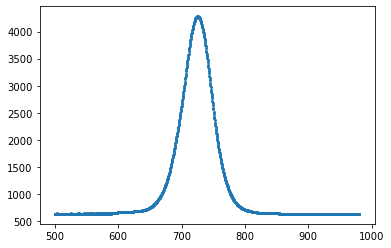

In [39]:
IBr2.PLs[10].plotW()

In [41]:
IBr2 = PLevol("MAPbI25Br75/")
# IBr2.avgseries
IBr2.narrow(Wmin=500)

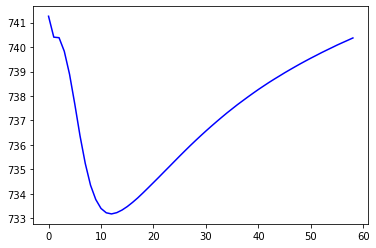

<Figure size 432x288 with 0 Axes>

In [42]:
fig = plt.figure()
plt.plot(IBr2.Wavgseries[1:],'b')
fig = plt.figure()

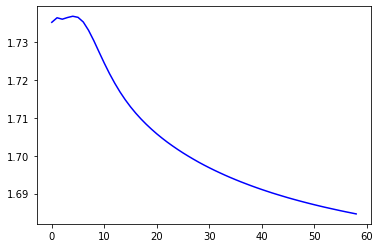

<Figure size 432x288 with 0 Axes>

In [43]:
fig = plt.figure()
plt.plot(IBr2.Eavgseries[1:],'b')
fig = plt.figure()

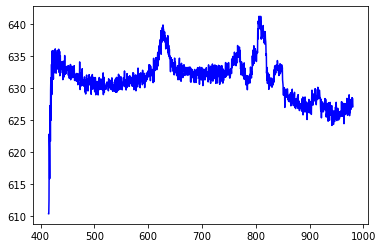

In [46]:
IBr2.PLs[0].plotW()

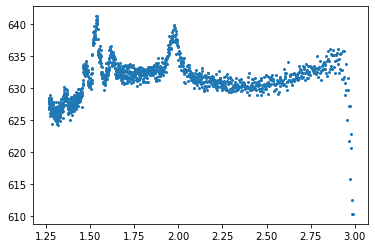

In [47]:
IBr2.PLs[0].plotE()

# Based on Online Tutorial
You can find it https://chrisostrouchov.com/post/peak_fit_xrd_python/.

In [357]:
from lmfit import models
from numpy import random
from scipy import signal

<IPython.core.display.Javascript object>


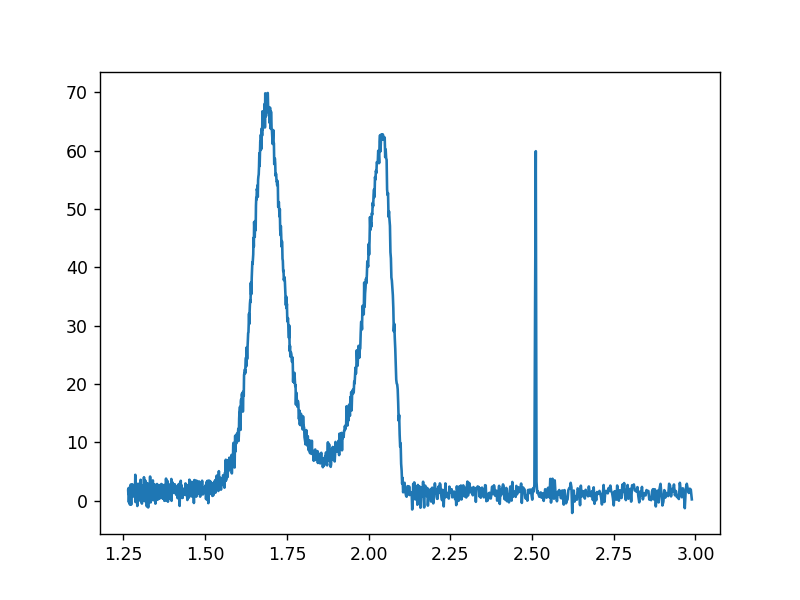

In [358]:
IBr2 = PLevol("MAPbI25Br75/")
index=2
x = IBr2.PLs[index].E 
y = IBr2.PLs[index].I - IBr2.PLs[0].I
fig, ax = plt.subplots()
ax.plot(x,y)

<IPython.core.display.Javascript object>


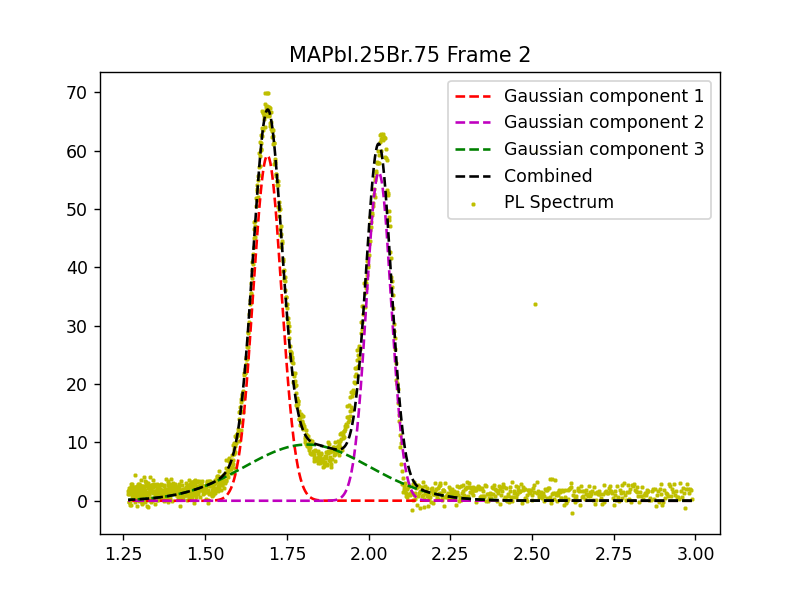

<IPython.core.display.Javascript object>


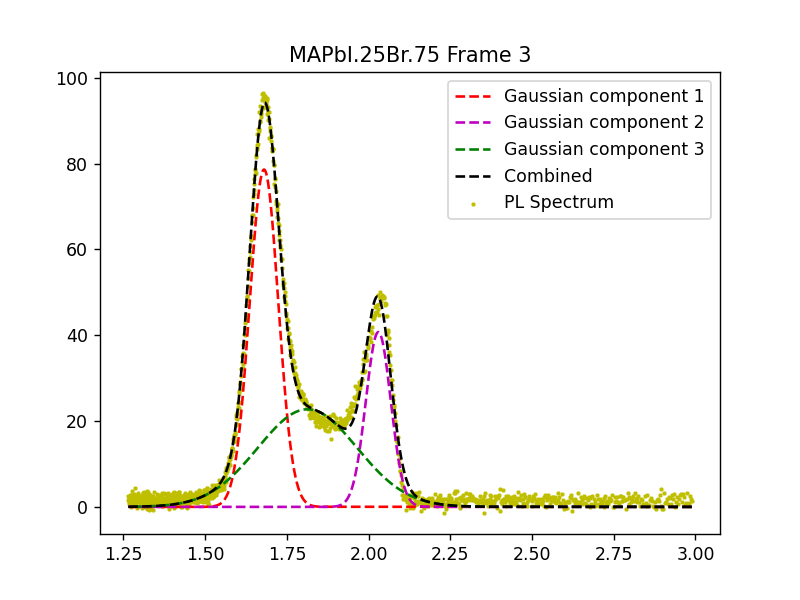

<IPython.core.display.Javascript object>


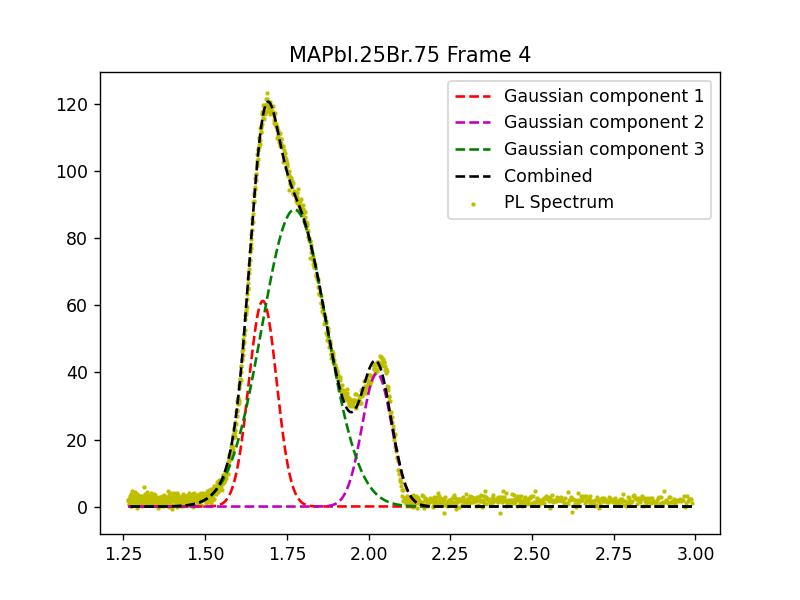

<IPython.core.display.Javascript object>


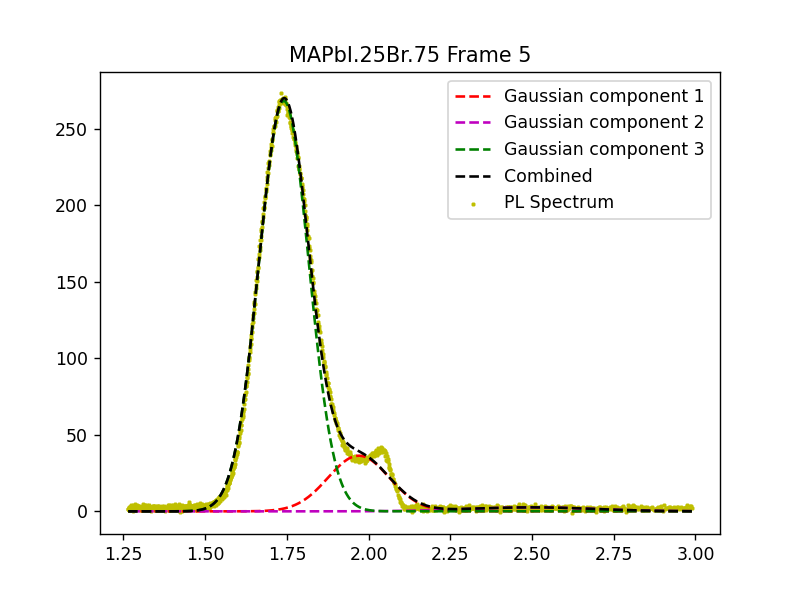

<IPython.core.display.Javascript object>


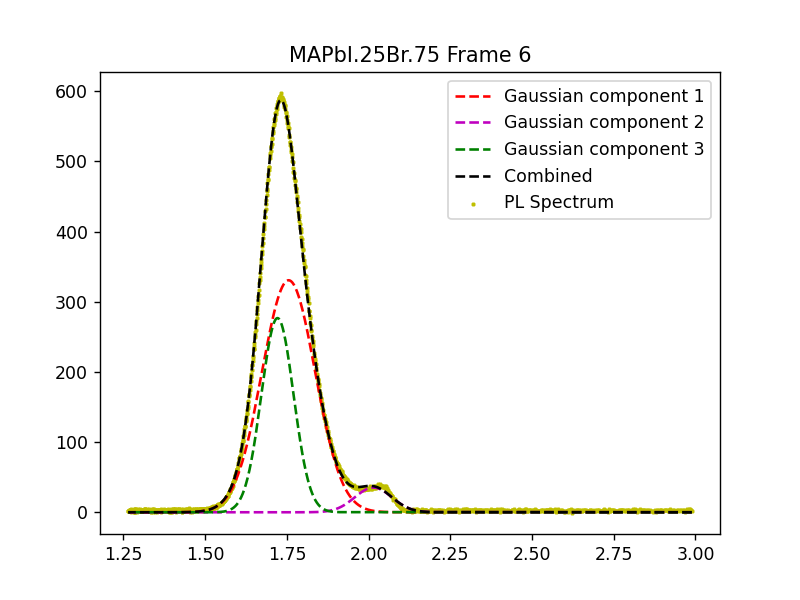

<IPython.core.display.Javascript object>


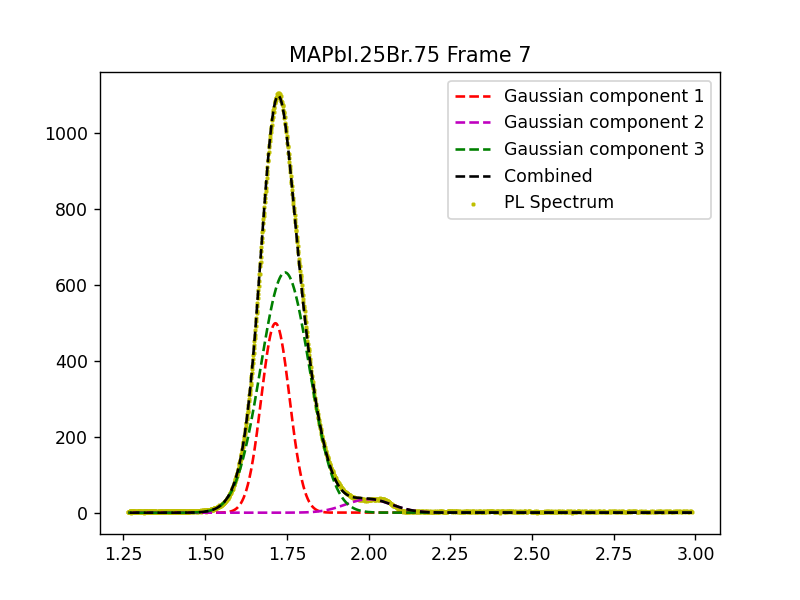

<IPython.core.display.Javascript object>


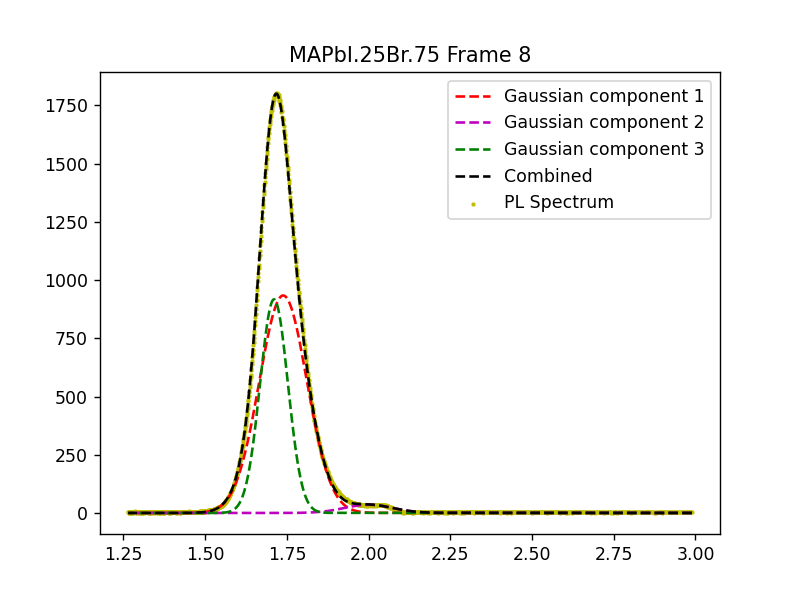

<IPython.core.display.Javascript object>


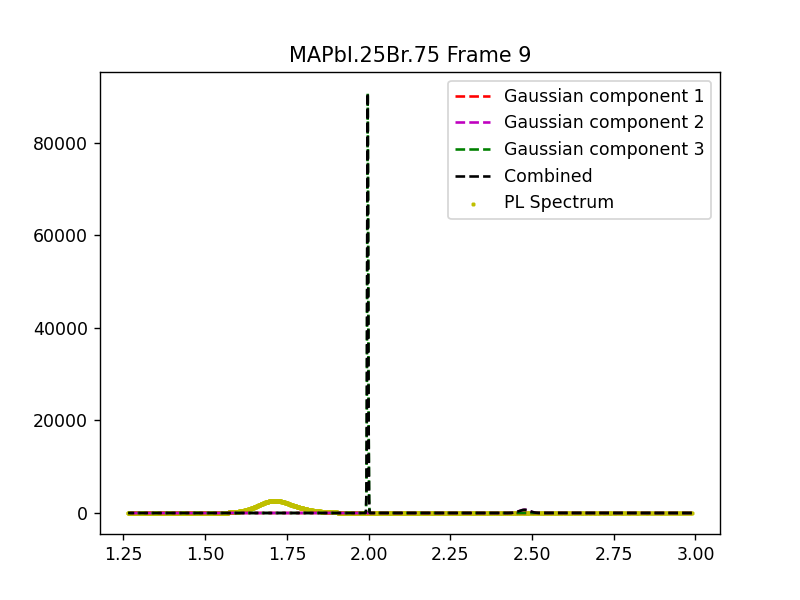

<IPython.core.display.Javascript object>


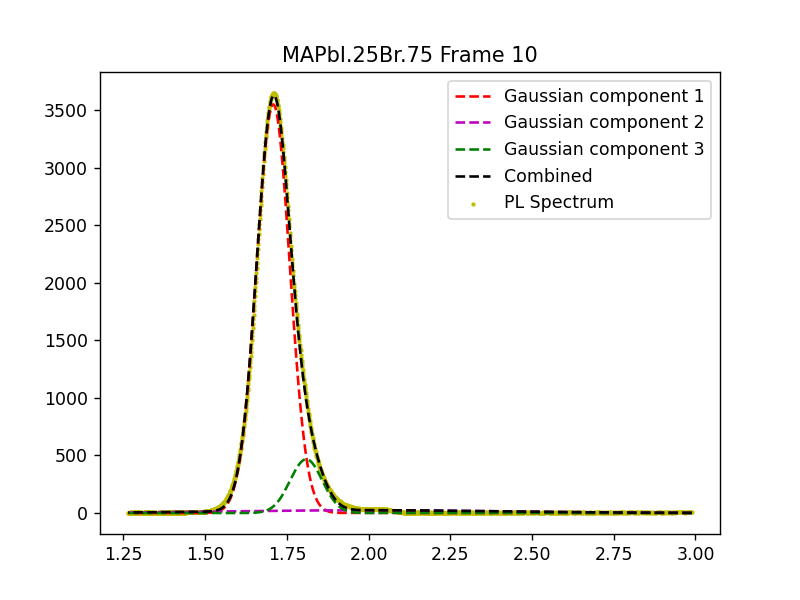

In [359]:
"""LMFIT Example"""
IBr2 = PLevol("MAPbI25Br75/")
for i in np.linspace(2,10,9):
    index=int(i)
    x = IBr2.PLs[index].E 
    y = IBr2.PLs[index].I - IBr2.PLs[0].I
    model_1 = models.GaussianModel(prefix='m1_')
    model_2 = models.GaussianModel(prefix='m2_')
    model_3 = models.GaussianModel(prefix='m3_')
    model = model_1 + model_2 + model_3

    params_1 = model_1.make_params(center=1.60, sigma=1)
    params_2 = model_2.make_params(center=2.029, sigma=1)
    params_3 = model_3.make_params(center=1.85, sigma=1)
    params = params_1.update(params_2)
    params = params.update(params_3)
    params["m1_center"].set(min=1.5,max=2.0)
    params["m2_center"].set(min=2.0,max=2.5)
    params["m3_center"].set(min=1.5,max=2)
    # params["m2_sigma"].set(max=9.0)

    output = model.fit(y, params, x=x)
    # fig, gridspec = output.plot(data_kws={'markersize': 1})
    fig, ax = plt.subplots()
    comps = output.eval_components(x=x)
    ax.scatter(x,y,s=3,marker="+",c="y",label='PL Spectrum')
    ax.plot(x, comps['m1_'], 'r--', label='Gaussian component 1')
    ax.plot(x, comps['m2_'], 'm--', label='Gaussian component 2')
    ax.plot(x, comps['m3_'], 'g--', label='Gaussian component 3')
    ax.plot(x, comps['m3_']+comps['m2_']+comps['m1_'], 'k--', label='Combined')
    ax.legend(loc='best')
    ax.set_title("MAPbI.25Br.75 Frame "+str(index))

In [362]:
output